### Import Packages

In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import os
import sys
import copy
from tensor_solver import TensorSolver

### Generating the 2-layer stochastic block model

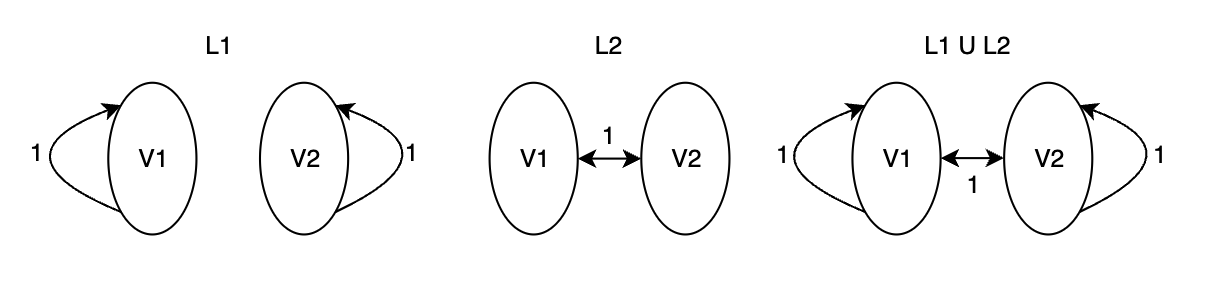

In [2]:
#probability q
_q = 0
#We make two stochastic block models G1(p, _q) and G1(_q, p)
def make_block_model(n = 100, p = 1, seed = 1):
    Ws = []
    true_list = [i for i in range(n)]
    
    #Layer 1 (L1)
    probs = [[p, _q], [_q, p]]
    G1 = nx.stochastic_block_model(sizes=[int(n/2), n-int(n/2)], p=probs, 
                                  seed = seed, nodelist=true_list, directed = False)
    A1 = nx.adjacency_matrix(G1)
    for i in range(n): 
        if np.sum(A1[i,:])==0: A1[i,i] = 1
    Ws.append(torch.from_numpy((A1.T*1/A1.sum(axis = 1).T).T))
    
    #Layer 2 (L2)
    probs = [[_q, p], [p, _q]]
    G2 = nx.stochastic_block_model(sizes=[int(n/2), n-int(n/2)], p=probs, 
                                  seed = seed, nodelist=true_list, directed = False)
    A2 = nx.adjacency_matrix(G2)
    for i in range(n): 
        if np.sum(A2[i,:])==0: A2[i,i] = 1
    Ws.append(torch.from_numpy((A2.T*1/A2.sum(axis = 1).T).T))
    
    #L1 U L2
    Ws.append((torch.from_numpy(((A1+A2).T*1/(A1+A2).sum(axis = 1).T).T)))
    
    return Ws

### Make initial opinions

In [3]:
#Initial Opinions s; nodes in V1 have opinion o1 and nodes in V2 have opinion o2.
def make_initial_opinions(n1 = 50, n2 = 50, o1 = 1, o2 = 0):
    s1 = o1 * np.ones(n1)
    s2 = o2 * np.ones(n2)
    return torch.from_numpy(np.concatenate([s1, s2]))

### Set Resistance Parameters (alphas)

In [4]:
#Resistance parameters alphas; sampled from normal distribution Normal(0.1, 0.1).
def make_resistance_parameters(n = 100, seed = 1):
    np.random.seed(seed)
    alphas = np.random.normal(0.1, 0.1, n)
    for i in range(len(alphas)):
        if alphas[i]>1: alphas[i] = 1
        if alphas[i]<0: alphas[i] = 0
    return torch.from_numpy(alphas)

### Set Layer Parameters (lambdas)

In [5]:
#Layer parameters lambdas = (lambda1, lambda2).T with lambda1 + lambda2 = 1.
def make_layer_parameters(n = 100, l = 0.25):
    lambda1 = l
    lambda2 = 1 - l
    return torch.from_numpy(np.array([lambda1, lambda2]))

### Predictions
$$x_u(t)=\alpha_us_u+(1-\alpha_u)\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{l,u}\mathbf{x}(t-1)$$

In [6]:
#Given initial opinions (s), the resistance parameters (alphas),
#the layer weights (lambdas), the weighted adjacency matrices (W) and 
#the opinions at time t (x(t)), function returns opinions at t+1 (x(t+1)).
def predict(s, alphas, lambdas, W, xt):
    n = len(s)
    xt_plus_1 = alphas*s
    for u in range(n): 
        for l in range(len(lambdas)):
            xt_plus_1[u] += float((1-alphas[u])*lambdas[l]*(W[l][u,:].reshape(1,n)@xt))
    return xt_plus_1

### Generate data using Multilayer FJ model.

In [7]:
def make_train_and_test_data(n = 100, p = 1, l = 1/4, T = 8, seed = 1):
    data = {}
    #model parameters
    data['W'] = make_block_model(n, p, seed)
    data['s'] = make_initial_opinions(int(n/2), n - int(n/2))
    data['alphas'] = make_resistance_parameters(n, seed)
    data['lambdas'] = make_layer_parameters(l)
    
    #generating data
    data['x'] = []
    data['x'].append(data['s'])
    for _ in range(T): 
        data['x'].append(predict(data['s'], data['alphas'], data['lambdas'], data['W'][0:2], data['x'][-1]))
    for i in range(T+1):
        data['x'][i] += torch.from_numpy(np.random.normal(0, 0, n))
        for j in range(n): 
            if data['x'][i][j]>1: data['x'][i][j] = 1
            if data['x'][i][j]<0: data['x'][i][j] = 0
    #return parameters and data
    return data

### Make the dataset

In [8]:
iters = 10
dataset = []
for i in range(iters): 
    dataset.append(make_train_and_test_data(n = 100, seed = 100*i+int(1*10)))

### Running Projected Gradient Descent 

In [9]:
#Run the experiments
def run_the_experiments(data_, T_train, T_test, algname = 'multi'):
    results = {}
    results['train_loss'] = []
    results['test_loss'] = []
    results['alphas'] = []
    results['lambdas'] = []
    for i in range(len(data_)):
        data = copy.deepcopy(data_)
        Ws_ = copy.deepcopy(data[i]['W'])
        n = len(Ws_[0])
        print(f'Algorithm {algname}')
        if algname == 'multi': Ws_ = [[data[i]['W'][0], data[i]['W'][1]]]
        elif algname == 'l1': Ws_ = [[data[i]['W'][0], data[i]['W'][0]]]
        elif algname == 'l2': Ws_ = [[data[i]['W'][1], data[i]['W'][1]]]
        elif algname == 'lboth': Ws_ = [[data[i]['W'][2], data[i]['W'][2]]]
        else: return
        x_train = [data[i]['x'][j].reshape(n, 1) for j in range(0,T_train)]
        y_train = [data[i]['x'][j].reshape(n, 1) for j in range(1,T_train+1)]
        x_test = [data[i]['x'][j].reshape(n, 1) for j in range(T_train, T_train+T_test)]
        y_test = [data[i]['x'][j].reshape(n, 1) for j in range(T_train+1, T_train+T_test+1)]
        
        solver  = TensorSolver(data[i]['s'].reshape(n,1), Ws_, x = x_train, y = y_train)
        train_loss = solver.training(num_epochs = 100, lrdiv = 10, printall = False, printL1 = True) #change False to True for printing loss
        test_loss = []
        for t in range(T_test):
            test_loss.append(torch.nn.L1Loss()(predict(data[i]['s'].reshape(n,1), 
                                                       solver.lambdas.detach()[:-2],
                                                       solver.lambdas.detach()[-2:].reshape(-1),
                                                       Ws_[0], 
                                                       x_test[t]).reshape(n,1), y_test[t].reshape(n,1)).numpy())
        print('Test Loss: ', test_loss)
        results['train_loss'].append(train_loss)
        results['test_loss'].append(np.mean(test_loss))
        results['alphas'].append(solver.lambdas.detach().numpy()[:-2])
        results['lambdas'].append(solver.lambdas.detach().numpy()[-2:])
        
    return results

T_train = 5
T_test = 3
alg_results = {}
for algname in ['multi', 'l1', 'l2', 'lboth']: 
    alg_results[algname] = run_the_experiments(dataset, T_train, T_test, algname)

Algorithm multi
Test Loss:  [array(0.0047092), array(0.00460624), array(0.00465179)]
Algorithm multi
Test Loss:  [array(0.00458316), array(0.00448085), array(0.00452643)]
Algorithm multi
Test Loss:  [array(0.00441223), array(0.00431135), array(0.00435721)]
Algorithm multi
Test Loss:  [array(0.00460424), array(0.0045011), array(0.00454604)]
Algorithm multi
Test Loss:  [array(0.00461795), array(0.00451394), array(0.00455824)]
Algorithm multi
Test Loss:  [array(0.0046654), array(0.00456204), array(0.00460698)]
Algorithm multi
Test Loss:  [array(0.00456727), array(0.00446521), array(0.00451094)]
Algorithm multi
Test Loss:  [array(0.00465844), array(0.00455554), array(0.00460102)]
Algorithm multi
Test Loss:  [array(0.00457521), array(0.00447164), array(0.00451592)]
Algorithm multi
Test Loss:  [array(0.00471931), array(0.0046155), array(0.00466041)]
Algorithm l1
Test Loss:  [array(0.06989664), array(0.08416021), array(0.07785039)]
Algorithm l1
Test Loss:  [array(0.07068467), array(0.08599081

### Average results

In [10]:
for algname in alg_results:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphas_mean'] = np.mean(alg_results[algname]['alphas'], axis = 0)
    alg_results[algname]['lambdas_mean'] = np.mean(alg_results[algname]['lambdas'], axis = 0)

### Plot average train loss vs epochs

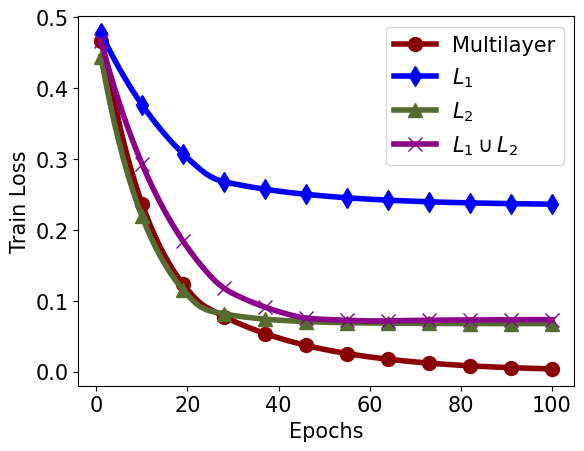

In [15]:
def plot_train_loss(alg_results):
    fig, axes = plt.subplots(1)
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    markers = ["o", "d", "^", "x"]
    ax1 = axes
    j = 0
    for algname in alg_results:
        ax1.plot(range(1, len(alg_results[algname]['train_loss_mean']) + 1), 
                 alg_results[algname]['train_loss_mean'], 
                 color = m[j], label = names_plot[j],linewidth=4.0,
                 marker = markers[j], markevery=9, markersize=10)
        j += 1
    plt.legend(fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Train Loss', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/train_loss_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_train_loss(alg_results)

### Plot average test loss 

multi -> 0.004557692853389955
l1 -> 0.07828516652325858
l2 -> 0.048672276944110485
lboth -> 0.0202600889332366


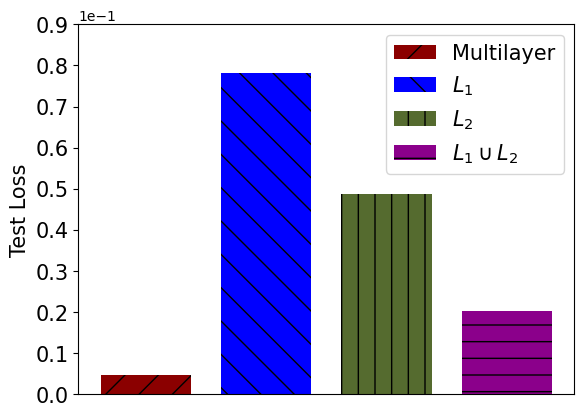

In [16]:
def plot_test_loss(alg_results):
    fig, axes = plt.subplots()
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    d = ['lightcoral', 'cornflowerblue', 'lightgreen', 'pink']
    c = ['indianred', 'royalblue', 'greenyellow', 'hotpink']
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    hatches = ['/', '\\', '|', '-']
    i = 0
    for algname in alg_results:
        x = np.arange(1)  # the label locations
        width = 0.15      # the width of the bars
        offset = width * i
        print(f'{algname} -> {alg_results[algname]["test_loss_mean"]}')
        axes.bar(x + offset, alg_results[algname]['test_loss_mean'], 3*width/4, 
                label=names_plot[i], color = m[i],
                hatch=hatches[i])
        i += 1
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    plt.ylim(top=0.09)
    plt.legend(fontsize=15)
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,-1))
    plt.ylabel('Test Loss', fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/test_loss_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_test_loss(alg_results)

### Plot distribution of average predicted alphas  

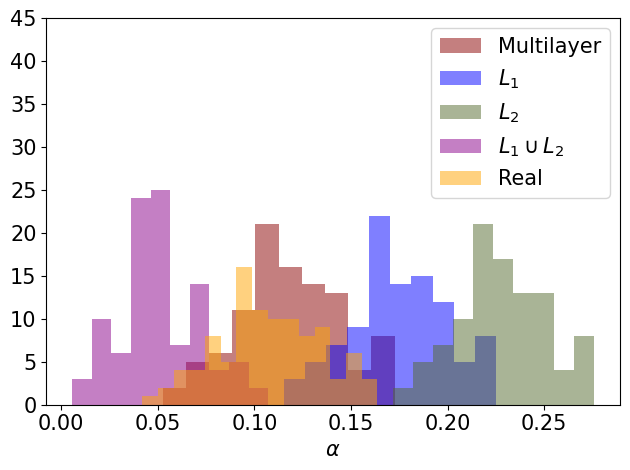

In [17]:
def plot_alphas_distribution(alg_results, real_alphas_mean):
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    i = 0
    for algname in alg_results:
        plt.hist(np.array(alg_results[algname]['alphas_mean']), bins=10, 
                 color = colors[i] ,label = names_plot[i], alpha = 0.5)
        i += 1
    plt.hist(np.array(real_alphas_mean), bins=15, 
             color = 'orange', label = 'Real', alpha = 0.5)
    plt.ylim(top=45)
    plt.legend()
    plt.legend(fontsize=15)
    plt.xlabel(r'$\alpha$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f'./Figures/alpha_distribution_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
real_alphas_mean = np.zeros(len(dataset[0]['alphas']))
for i in range(len(dataset)):
    real_alphas_mean += (dataset[i]['alphas'].numpy())/len(dataset)
plot_alphas_distribution(alg_results, real_alphas_mean)

### Predicted layer parameters

In [14]:
for algname in alg_results:
    print(f'For {algname} lambdas are: {alg_results[algname]["lambdas_mean"].T[0]}')

For multi lambdas are: [0.24234439 0.75765561]
For l1 lambdas are: [0.5 0.5]
For l2 lambdas are: [0.5 0.5]
For lboth lambdas are: [0.5 0.5]
